
# A Notebook to explore gridded climate time series data and DHSVM modeling of the Sauk-Suiattle Watershed  
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:200px;padding:20px">   
This data is compiled to digitally observe the Sauk-Suiattle Watershed, powered by HydroShare. <br />
<br />
*Use this Jupyter Notebook to:* <br /> 
Download and generate lists of gridded climate points for a watershed<br />
Download Livneh daily 1/16 degree gridded climate data, <br /> 
Download WRF daily 1/16 degree gridded climate data, <br /> 
Visualize daily, monthly, and annual temperature and precipitation data. <br /> 
Calculate Long-term Mean Monthly Bias Corrections for WRF using Livneh Low Elevation data<br /> 
Bias correct each Livneh grid cell using bias corrected WRF (use to correct Livneh 2013 and MACA data). <br />
Visualize daily, monthly, and annual temperature and precipitation data with corrected results. <br /> 
Update VIC model soil input (optional). <br /> 
Save results back to HydroShare. <br /> 
 <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

This is the Livneh bias correction to WRF, that is bias corrected to the Livneh low elevation long term mean, which has been spatially averaged (with a few experimental GIS selections).  

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
#!python3 -m pip install descartes

In [2]:
#Python libraries available on CUAHSI JupyterHub 
import os
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta

%matplotlib inline
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

#HydroShare Utilities
from utilities import hydroshare

#UW Watershed Dynamics Lab Utilities
import ogh

In [3]:
start_time=datetime.now()

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [4]:
hs=hydroshare.hydroshare()
homedir = ogh.mapContentFolder(str(os.environ["HS_RES_ID"]))
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = cbev
   HS_RES_ID = 0236ae196d204f1cba421787f38dec71
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => cbev
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/0236ae196d204f1cba421787f38dec71/0236ae196d204f1cba421787f38dec71/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Download and generate lists of gridded climate points for a watershed
Retrieve a list of grid points and configuration file from a HydroShare resource
This example uses a ascii text that is stored in HydroShare at the following url: https://www.hydroshare.org/resource/d90289409f904017831d308642c1eb30/ . The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the table in this resource is the 'mappingfile' variable identifying the Lat/Long points to be used for downloading hydrometeorology data.  The file must include columns with station numbers (this can be aribitrary), latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.

### User provides their HydroShare resource ID from their own polgyon shapefile uploaded to HydroShare

In [5]:
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
shapefile = hs.content['wbdhuc12_17110006_WGS84.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


### Use TreatGeoSelf to generate a list of lat/long points in your area of interest

In [6]:
#This is the exising point shapefile of available 1/16 degree grid centroid locations 
# shared on HydroShare as a public resource
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

# TreatGeoSelf() to a easily generated list of lat/long points in your area of interest
mappingfile = ogh.treatgeoself(shapefile=shapefile, NAmer=NAmer, folder_path=os.getcwd(), outfilename='monkeysonatree.csv', buffer_distance=0.06)
print(mappingfile)

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


Number of gridded points/files: 98
(98, 4)
    FID       LAT      LONG_    ELEV
93   93  47.96875 -121.53125   987.0
94   94  47.90625 -121.21875  1310.0
95   95  47.90625 -121.28125  1061.0
96   96  47.90625 -121.34375   934.0
97   97  47.90625 -121.40625   866.0
/home/jovyan/work/notebooks/Observatory/monkeysonatree.csv


### INPUT: Location Name and watershed drainage area (m2)

In [7]:
loc_name='Sauk Watershed'
streamflow_watershed_drainage_area=1849242318 # square meters

# read in the metadata file

In [8]:
with open('ogh_meta.json','r') as r:
    meta_file = json.load(r)
    r.close()

sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

 ## 3. Download climate data 

### Get Daily Meteorologic Data (1915-2011) from Livneh et al. 2013 

The functions used in this section apply to hydrometeorology data within the Continental United States with daily data 1915-2011. <br/>
View data extent at  Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite: <br/>
Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.<br/>
<br/>
The getClimateData_DailyMET_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

In [9]:
help(ogh.getDailyMET_livneh2013)

Help on function getDailyMET_livneh2013 in module ogh:

getDailyMET_livneh2013(homedir, mappingfile, subdir='livneh2013/Daily_MET_1915_2011/raw', catalog_label='dailymet_livneh2013')
    Get the Livneh el al., 2013 Daily Meteorology files of interest using the reference mapping file
    
    homedir: (dir) the home directory to be used for establishing subdirectories
    mappingfile: (dir) the file path to the mappingfile, which contains the LAT, LONG_, and ELEV coordinates of interest
    subdir: (dir) the subdirectory to be established under homedir
    catalog_label: (str) the preferred name for the series of catalogged filepaths



In [10]:
Daily_MET_1915_2011 = ogh.getDailyMET_livneh2013(homedir, mappingfile)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.53125_-121.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.28125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.21875_-120.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.46875_-121.65625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_


### Get Daily Weather Research and Forecasting (WRF 1950-2010 Pacific Northwest) from Salathe et al., 2014
<br/>
Please cite 2014 data using: <br/>
Salathé, EP, AF Hamlet, CF Mass, M Stumbaugh, S-Y Lee, R Steed: 2017. Estimates of 21st Century Flood Risk in the Pacific Northwest Based on Regional Scale Climate Model Simulations.  J. Hydrometeorology. DOI: 10.1175/JHM-D-13-0137.1

This data is also available on HydroShare and can be downloaded using the following line of code (copy into code block):
hs.getResourceFromHydroShare('0db969e4cfb54cb18b4e1a2014a26c82')


In [11]:
help(ogh.getDailyWRF_salathe2014)

Help on function getDailyWRF_salathe2014 in module ogh:

getDailyWRF_salathe2014(homedir, mappingfile, subdir='salathe2014/WWA_1950_2010/raw', catalog_label='dailywrf_salathe2014')
    Get the Salathe el al., 2014 raw Daily WRF files of interest using the reference mapping file
    
    homedir: (dir) the home directory to be used for establishing subdirectories
    mappingfile: (dir) the file path to the mappingfile, which contains the LAT, LONG_, and ELEV coordinates of interest
    subdir: (dir) the subdirectory to be established under homedir
    catalog_label: (str) the preferred name for the series of catalogged filepaths



In [12]:
Daily_WRFraw_1950_2010 = ogh.getDailyWRF_salathe2014(homedir, mappingfile)

downloaded: data_48.53125_-121.59375
downloaded: data_48.46875_-121.53125
downloaded: data_48.46875_-121.65625
downloaded: data_48.40625_-121.28125
downloaded: data_48.40625_-121.40625
downloaded: data_48.40625_-121.15625
downloaded: data_48.40625_-121.53125
downloaded: data_48.34375_-121.03125
downloaded: data_48.40625_-121.65625
downloaded: data_48.34375_-121.15625
downloaded: data_48.34375_-121.28125
downloaded: data_48.34375_-121.40625
downloaded: data_48.34375_-121.53125
downloaded: data_48.28125_-120.96875
downloaded: data_48.28125_-121.09375
downloaded: data_48.28125_-121.21875
downloaded: data_48.28125_-121.34375
downloaded: data_48.28125_-121.59375
downloaded: data_48.28125_-121.46875
downloaded: data_48.21875_-120.90625
downloaded: data_48.46875_-121.46875
downloaded: data_48.46875_-121.59375
downloaded: data_48.40625_-121.09375
downloaded: data_48.40625_-121.34375
downloaded: data_48.40625_-121.46875
downloaded: data_48.40625_-121.21875
downloaded: data_48.40625_-121.59375
d

Helpful hint: Jupyter Notebooks on the CUAHSI JupyterHub server on ROGER supercomputer can use Python or bash command line coding to explore the data folders.  Alternatively, you can click on the orange Jupyter icon in the upper left corner to open the folder view to see where in the world your files are.

In [13]:
print('This is the list of folders in your directory for this HydroShare resource.')
test = [each for each in os.listdir(homedir) if os.path.isdir(each)]
print(test)

This is the list of folders in your directory for this HydroShare resource.
['salathe2014', 'livneh2013', 'biascorrWRF_liv']


## 4.  Calculate Long-term Monthly Bias Corrections for WRF using Livneh Low Elevation data

In [19]:
# take two tuples representing start and end date ranges, then find their overlapping date_range
dr1 = meta_file['dailymet_livneh2013']['date_range']
dr2 = meta_file['dailywrf_salathe2014']['date_range']

dr = ogh.overlappingDates(tuple([dr1['start'],dr1['end']]), tuple([dr2['start'],dr2['end']]))
dr

('1950-01-01', '2010-12-31')

In [20]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                               loc_name=loc_name,
                               dataset='dailymet_livneh2013',
                               mappingfile=mappingfile, 
                               metadata=meta_file,
                               file_start_date=None, 
                               file_end_date=None,
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                               loc_name=loc_name,
                               dataset='dailywrf_salathe2014',
                               mappingfile=mappingfile, 
                               metadata=meta_file,
                               file_start_date=None, 
                               file_end_date=None,
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_0to3000)

sorted(ltm_0to3000.keys())

   FID       LAT      LONG_    ELEV  \
0    0  48.53125 -121.59375  1113.0   
1    1  48.46875 -121.46875   646.0   
2    2  48.46875 -121.53125   321.0   
3    3  48.46875 -121.59375   164.0   
4    4  48.46875 -121.65625   369.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailywrf_salathe2014',
 'analysis_elev_max',
 'analysis_elev_max_cutoff',
 'analysis_elev_min',
 'analysis_elev_min_cutoff',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailywrf_salathe2014',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'anom_year_WINDSPD_dailywrf_salathe2014',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailywrf_salathe2014',
 'meanallyear_TMAX_dailymet_livneh2013',
 'meanallyear_TMAX_dailywrf_salathe2014',
 'meanallyear_TMIN_dailymet_livneh2013',
 'meanallyear_TMIN_dailywrf_salathe2014',
 'meanallyear_WINDSPD_dailymet_livneh2013',
 'meanallyear_WINDSPD_dailywr

## 5. Perform bias correction using differences between WRFbc (from 4) and Liv2013

In [21]:
BiasCorr_wrfbc = ogh.compute_diffs(df_dict=ltm_0to3000, df_str='0to3000m',
                                   gridclimname1='dailywrf_salathe2014',
                                   gridclimname2='dailymet_livneh2013',
                                   prefix2=['month'],
                                   prefix1=meta_file['dailymet_livneh2013']['variable_list'])

print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')

print(sorted(BiasCorr_wrfbc.keys()))

Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m
['PRECIP_0to3000m', 'TMAX_0to3000m', 'TMIN_0to3000m', 'WINDSPD_0to3000m']


In [22]:
datetime.now()-start_time

datetime.timedelta(0, 558, 692957)

In [23]:
Daily_MET_1915_2011_WRFbc_liv, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile,
                                                           BiasCorr=BiasCorr_wrfbc,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorrWRF_liv')

   FID       LAT      LONG_    ELEV  \
0    0  48.53125 -121.59375  1113.0   
1    1  48.46875 -121.46875   646.0   
2    2  48.46875 -121.53125   321.0   
3    3  48.46875 -121.59375   164.0   
4    4  48.46875 -121.65625   369.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

In [24]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                                loc_name=loc_name,
                                dataset='dailymet_livneh2013_wrfbc',
                                mappingfile=mappingfile, 
                                metadata=meta_file,
                                file_colnames=None,
                                file_delimiter=None,
                                file_start_date=None, 
                                file_end_date=None,
                                file_time_step=None,
                                subset_start_date=dr[0],
                                subset_end_date=dr[1],
                                df_dict=ltm_0to3000)

sorted(ltm_0to3000.keys())

   FID       LAT      LONG_    ELEV  \
0    0  48.53125 -121.59375  1113.0   
1    1  48.46875 -121.46875   646.0   
2    2  48.46875 -121.53125   321.0   
3    3  48.46875 -121.59375   164.0   
4    4  48.46875 -121.65625   369.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailymet_livneh2013_wrfbc',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013_wrfbc',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013_wrfbc',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013_wrfbc',
 'WINDSPD_dailywrf_salathe2014',
 'analysis_elev_max',
 'analysis_elev_max_cutoff',
 'analysis_elev_min',
 'analysis_elev_min_cutoff',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013_wrfbc',
 'anom_year_TMIN_dailywrf_salathe2014',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'anom_year_WINDSPD_dailymet_livneh2013_wrfbc',
 'anom_year_WINDSPD_dailywrf_salathe201

In [25]:
datetime.now()-start_time

datetime.timedelta(0, 629, 540549)

In [26]:
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2013_wrfbc',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 22280 (major_axis) x 98 (minor_axis)
Items axis: TMAX_dailymet_livneh2013 to TMAX_dailywrf_salathe2014
Major_axis axis: 1950-01-01 00:00:00 to 2010-12-31 00:00:00
Minor_axis axis: (0, 48.53125, -121.59375) to (97, 47.90625, -121.40625)
Axes(0.125,0.125;0.775x0.755)


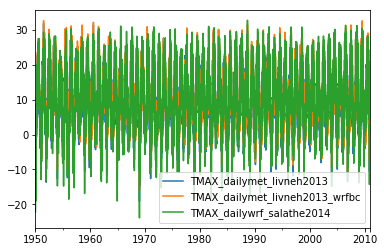

In [27]:
# let's compare daily values for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['TMAX_dailymet_livneh2013', 'TMAX_dailywrf_salathe2014', 'TMAX_dailymet_livneh2013_wrfbc']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
        panel_obj = pd.Panel.from_dict(obj)
print(panel_obj)

print(panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2).plot())

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 12 (major_axis) x 98 (minor_axis)
Items axis: month_TMAX_dailymet_livneh2013 to month_TMAX_dailywrf_salathe2014
Major_axis axis: 1 to 12
Minor_axis axis: (0, 48.53125, -121.59375) to (97, 47.90625, -121.40625)


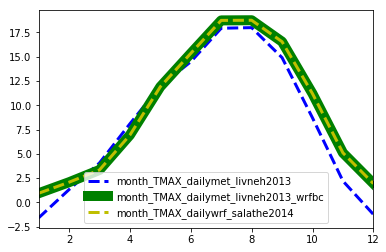

In [28]:
# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['month_TMAX_dailymet_livneh2013','month_TMAX_dailymet_livneh2013_wrfbc','month_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
panel_obj = pd.Panel.from_dict(obj)
print(panel_obj)

fig, ax = plt.subplots()
lws=[3, 10, 3]
styles=['b--','go-','y--']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)

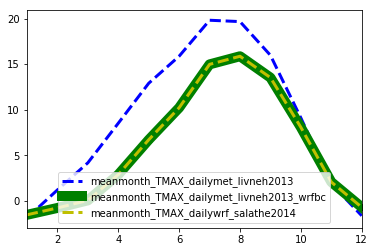

In [35]:
comp = ['meanmonth_TMAX_dailymet_livneh2013', 'meanmonth_TMAX_dailymet_livneh2013_wrfbc', 'meanmonth_TMAX_dailywrf_salathe2014']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 

df_obj = pd.DataFrame.from_dict(obj)

fig, ax = plt.subplots()
lws=[3, 10, 3]meanallyear_PRECIP_dailymet_livneh2013_wrfbc
styles=['b--','go-','y--']

for col, style, lws in zip(comp, styles, lws):
    df_obj[col].plot(style=style, lw=lws, ax=ax, legend=True)

In [33]:
#initiate new dictionary with original data
#ltm_deltaTratioP_0to3000_v2 = dict(ltm_deltaTratioP_0to3000)
#initiate new dictionary with original data
livbc_0to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011,
                               gridclimname='liv2013_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile, 
                               min_elev=0,
                               max_elev=3000,
                               file_start_date=datetime(1915,1,1), 
                               file_end_date=datetime(2011,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31))    

livbc_0to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_WRFraw_1950_2010,
                               gridclimname='wrf2014_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile,
                               min_elev=0,
                               max_elev=3000,
                               file_start_date=datetime(1950,1,1), 
                               file_end_date=datetime(2010,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31),  
                               df_dict=livbc_0to3000)
#add corrected data to the dictionary and plot
livbc_0to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011_WRFbc_liv,
                                               gridclimname='livneh2013_wrf2014bc_met_daily',
                                               loc_name=loc_name,
                                               mappingfile=mappingfile,
                                               min_elev=0,
                                               max_elev=3000,
                                               file_start_date=datetime(1915,1,1),
                                               file_end_date=datetime(2011,12,31),
                                               subset_start_date=datetime(1950,1,1),
                                               subset_end_date=datetime(2010,12,31),
                                               df_dict=livbc_0to3000)
dictionary=livbc_0to3000
loc_name='Sauk Watershed - Liv2013 corrected to bias corrected WRF'
start_date=datetime(1950,1,1)
end_date=datetime(2010,12,31)

ogh.plot_meanP(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTavg(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmin(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmax(dictionary, loc_name, start_date, end_date)

   FID       LAT      LONG_    ELEV  \
0    0  48.53125 -121.59375  1113.0   
1    1  48.46875 -121.46875   646.0   
2    2  48.46875 -121.53125   321.0   
3    3  48.46875 -121.59375   164.0   
4    4  48.46875 -121.65625   369.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/0236ae196d204...   
1  /home/jovyan/work/notebooks/data/0236ae196d204...   
2  /home/jovyan/work/notebooks/data/0236ae196d204...   
3  /home/jovyan/work/notebooks/data/0236ae196d204...   
4  /home/jovyan/work/notebooks/data/0236ae196d204...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

ValueError: Must provide freq argument if no data is supplied

In [ ]:
#initiate new dictionary with original data
#ltm_deltaTratioP_0to3000_v2 = dict(ltm_deltaTratioP_0to3000)
#initiate new dictionary with original data
livbc_1500to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011,
                               gridclimname='liv2013_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile, 
                               min_elev=1500,
                               max_elev=3000,
                               file_start_date=datetime(1915,1,1), 
                               file_end_date=datetime(2011,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31))    

livbc_1500to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_WRFraw_1950_2010,
                               gridclimname='wrf2014_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile,
                               min_elev=1500,
                               max_elev=3000,
                               file_start_date=datetime(1950,1,1), 
                               file_end_date=datetime(2010,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31),  
                               df_dict=livbc_1500to3000)
#add corrected data to the dictionary and plot
livbc_1500to3000 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011_WRFbc_liv,
                                                gridclimname='livneh2013_wrf2014bc_met_daily',
                                               loc_name=loc_name,
                                               mappingfile=mappingfile,
                                               min_elev=1500,
                                               max_elev=3000,
                                               file_start_date=datetime(1915,1,1),
                                               file_end_date=datetime(2011,12,31),
                                               subset_start_date=datetime(1950,1,1),
                                               subset_end_date=datetime(2010,12,31),
                                               df_dict=livbc_1500to3000)
dictionary=livbc_1500to3000
loc_name='Sauk Watershed - Liv2013 corrected to bias corrected WRF'
start_date=datetime(1950,1,1)
end_date=datetime(2010,12,31)

ogh.plot_meanP(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTavg(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmin(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmax(dictionary, loc_name, start_date, end_date)

In [ ]:
#initiate new dictionary with original data
#ltm_deltaTratioP_0to3000_v2 = dict(ltm_deltaTratioP_0to3000)
#initiate new dictionary with original data
livbc_0to500 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011,
                               gridclimname='liv2013_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile, 
                               min_elev=0,
                               max_elev=500,
                               file_start_date=datetime(1915,1,1), 
                               file_end_date=datetime(2011,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31))    

livbc_0to500 = ogh.sand_between_your_toes(gridclim_folder=Daily_WRFraw_1950_2010,
                               gridclimname='wrf2014_met_daily',
                               loc_name=loc_name,
                               mappingfile=mappingfile,
                               min_elev=0,
                               max_elev=500,
                               file_start_date=datetime(1950,1,1), 
                               file_end_date=datetime(2010,12,31),
                               subset_start_date=datetime(1950,1,1),
                               subset_end_date=datetime(2010,12,31),  
                               df_dict=livbc_0to500)
#add corrected data to the dictionary and plot
livbc_0to500 = ogh.sand_between_your_toes(gridclim_folder=Daily_MET_1915_2011_WRFbc_liv,
                                                gridclimname='livneh2013_wrf2014bc_met_daily',
                                               loc_name=loc_name,
                                               mappingfile=mappingfile,
                                          min_elev=0,
                               max_elev=500,
                                               file_start_date=datetime(1915,1,1),
                                               file_end_date=datetime(2011,12,31),
                                               subset_start_date=datetime(1950,1,1),
                                               subset_end_date=datetime(2010,12,31),
                                               df_dict=livbc_0to500)
dictionary=livbc_0to500
loc_name='Sauk Watershed - Liv2013 corrected to bias corrected WRF'
start_date=datetime(1950,1,1)
end_date=datetime(2010,12,31)

ogh.plot_meanP(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTavg(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmin(dictionary, loc_name, start_date, end_date)
ogh.plot_meanTmax(dictionary, loc_name, start_date, end_date)

In [ ]:
sum(dictionary['meanmonth_precip_livneh2013_wrf2014bc_met_daily']-dictionary['meanmonth_precip_wrf2014_met_daily'])

#bias at P*0.95 = -3.147
#bias at P*0.925 = -5.44
#bias at P*0.98 = -0.395
#bias at P*0.985 = 0.064
#bias at P*0.984 = -0.0275
#bias at P*0.9842 = -0.009224

## 6. (optional) - Run MetSim to dissagregate daily data to 3-hrly DHSVM inputs

See [Observatory_Sauk_MetSim_Python3.ipynb](https://jupyter.cuahsi.org/user/christinabandaragoda/notebooks/notebooks/data/f0f90f5645864e0d9c0e0209d0095d74/f0f90f5645864e0d9c0e0209d0095d74/data/contents/Observatory_Sauk_MetSim_Python3.ipynb) 
Edit this Markdown code hyperlink to your User Name.



## 7. (optional) - Update VIC model input file: soil

In [ ]:
ogh.switchUpVICSoil(input_file=os.path.join(homedir,'soil_base'),
                    output_file='soil',
                    mappingfile=mappingfile,
                    homedir=homedir)

## 8. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

Move each file on the server within the 'files' list to an :EXISTING" HydroShare Generic Resource content folder.  Parent_resource is the destination resource ID for an existing Generic Resource. Files is a list of filepaths.

In [ ]:
"""
# Talk to CUAHSI about why the add file function is throwing errors
"""
#parent_resource = '0236ae196d204f1cba421787f38dec71'
#files= ['Observatory_Sauk_071117.ipynb'] #os.path.join(homedir,)

#response_json = hs.addContentToExistingResource(resid=parent_resource, content=files)

In [ ]:
!ls
!cp ../../../../../utilities/observatory_gridded_hydromet.py .

In [ ]:
ThisNotebook='Observatory_Sauk_LivBC2WRF_091817.ipynb' #check name for consistency
liv2013_tar = 'livneh2013.tar.gz'
wrf_tar = 'Salathe2014.tar.gz'
biascorrWRF_liv_tar = 'biascorrWRF_WRFbc.tar.gz'
observatory_gridded_hydromet='observatory_gridded_hydromet.py'
!tar -zcf {liv2013_tar} livneh2013
!tar -zcf {wrf_tar} Salathe2014
!tar -zcf {biascorrWRF_liv_tar} biascorrWRF_liv

files=[ThisNotebook,
       liv2013_tar,
       observatory_gridded_hydromet,
       wrf_tar,
       biascorrWRF_liv_tar]

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Sauk-Suiattle Observatory Bias Correction Results - Livneh et al., 2013 to WRF (Salathe et al., 2014)'
abstract = 'This output is a bias correction test to generate a hybrid gridded meteorology product'
keywords = ['Sauk', 'climate', 'WRF','hydrometeorology'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)